In [1]:
import cv2
import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
from ultralytics import YOLO
import chess
import chess.svg
%matplotlib inline

In [2]:
for i in tqdm.tqdm(range(10)):
    time.sleep(0.1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
cwd = os.getcwd()
os.chdir(cwd)
sys.path.append(cwd)

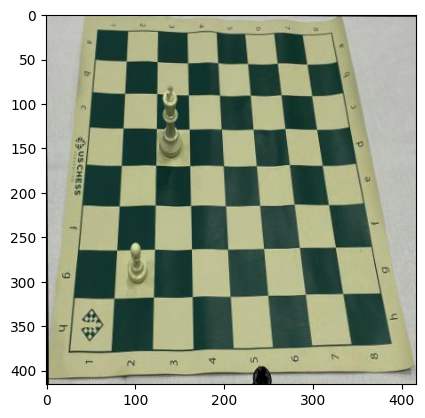

In [4]:
img = cv2.imread("Test/lessmultichess.jpg")
plt.imshow(img[:,:,::-1])
plt.show()

Text(0.5, 1.0, 'Canny Edge Detection')

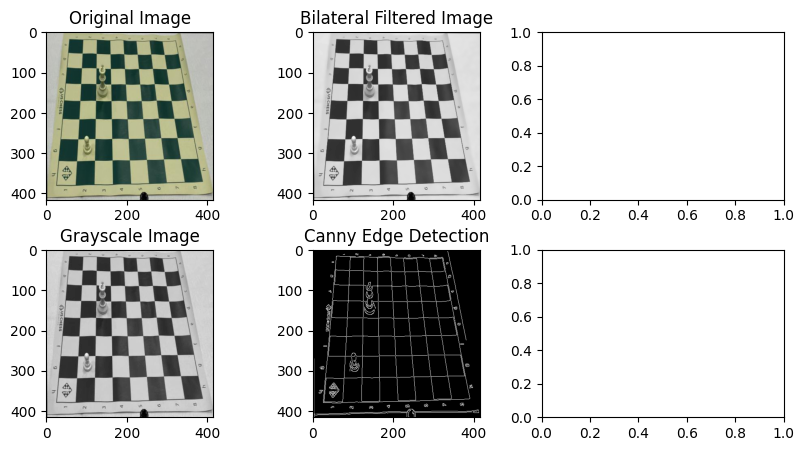

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
img = cv2.imread("Test/lessmultichess.jpg")
ax[0, 0].imshow(img[:,:,::-1])
ax[0,0].set_title('Original Image')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax[1, 0].imshow(gray, cmap='gray')
ax[1,0].set_title('Grayscale Image')

# Apply bilateral filter ; denoising
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Bilateral Filtered Image')


# Apply Canny edge detection
edged = cv2.Canny(gray, 50, 150)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edge Detection')


# # Apply Hough line transform
# lines = cv2.HoughLinesP(edged, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
# for line in lines:
#     x1, y1, x2, y2 = line[0]
#     cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# plt.imshow(img[:, :, ::-1])
# plt.show()

# # Detect grid intersections
# def find_intersections(lines):
#     points = []
#     for i, line1 in enumerate(lines):
#         for line2 in lines[i+1:]:
#             x1, y1, x2, y2 = line1[0]
#             x3, y3, x4, y4 = line2[0]
#             denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
#             if denom != 0:
#                 px = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / denom
#                 py = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / denom
#                 points.append((int(px), int(py)))
#     return points

# intersections = find_intersections(lines)
# for point in intersections:
#     cv2.circle(img, point, 5, (0, 255, 0), -1)

# plt.imshow(img[:, :, ::-1])
# plt.show()

In [6]:
def preprocess(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (3,3),1)
    img_threshold = cv2.adaptiveThreshold(img_blur, 255,1,1,11,2)
    return img_threshold

def reorder(pts):
    pts = pts.reshape((4,2))
    new_pts = np.zeros((4,1,2))
    sum = pts.sum(1)
    new_pts[0] = pts[np.argmin(sum)]
    new_pts[3] = pts[np.argmax(sum)]
    diff = np.diff(pts,axis=1)
    new_pts[1] = pts[np.argmin(diff)]
    new_pts[2] = pts[np.argmax(diff)]
    return new_pts

def findBiggestContour(contours):
    pts = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i,0.02*peri,True)
            if area > max_area and len(approx) == 4:
                pts = approx
                max_area = area
    return reorder(pts), max_area

def find_board_corners(img):
    processed_img = preprocess(img)
    contours, heirarchy = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    biggest, maxArea = findBiggestContour(contours)
    return biggest
    
def crop_board(img, corners):
    original_img = np.float32(corners)
    new_img = np.float32([[0, 0], [WIDTH, 0], [0, HEIGHT], [WIDTH, HEIGHT]])
    matrix = cv2.getPerspectiveTransform(original_img, new_img)
    imgWarpColored = cv2.warpPerspective(img, matrix, (WIDTH, HEIGHT))
    return imgWarpColored

def get_cells(img):
    rows = np.vsplit(img,8)
    cells = [[],[],[],[],[],[],[],[]]
    for r in range(8):
        cols = np.hsplit(rows[r], 8)
        for c in cols:
            cells[r].append(c)
    return cells

[[[         58          17]]

 [[        322          21]]

 [[         25         380]]

 [[        388         370]]]
Corner [[[         58          17]]

 [[        322          21]]

 [[         25         380]]

 [[        388         370]]]


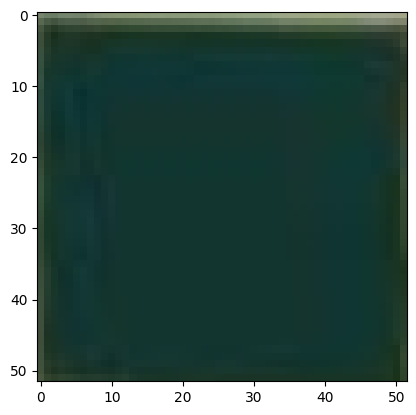

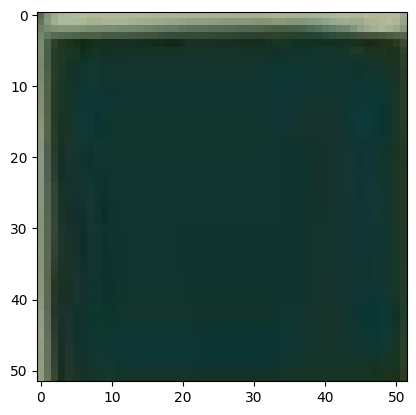

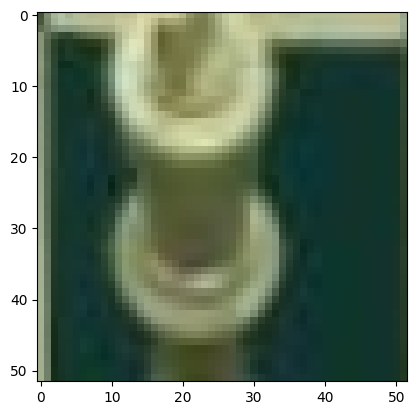

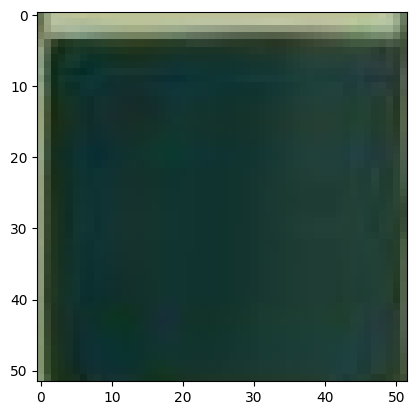

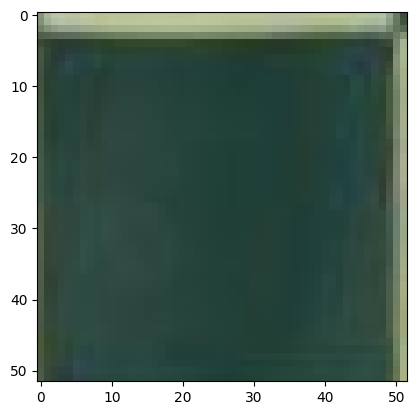

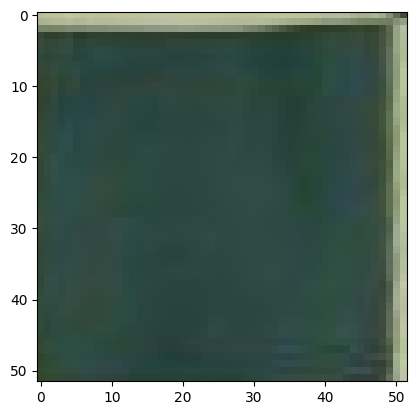

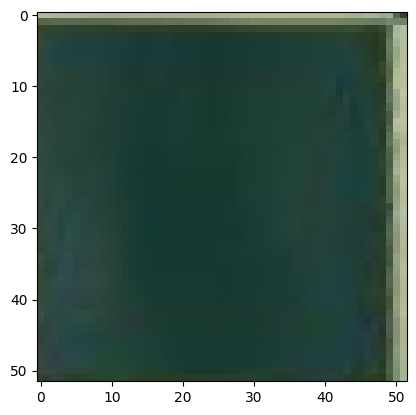

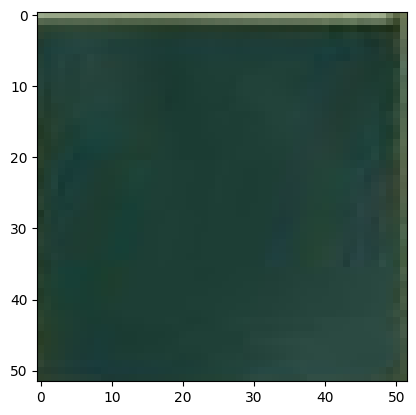

In [7]:
HEIGHT = 416
WIDTH = 416
img = cv2.imread("Test/lessmultichess.jpg")
preprocessed_img = preprocess(img)
plt.imshow(preprocessed_img, cmap='gray')

reordered_corners = find_board_corners(img)
print(reordered_corners)

corner = find_board_corners(img)
print('Corner',corner)

cropboard = crop_board(img, corner)
plt.imshow(cropboard[:,:,::-1])

getCell = get_cells(cropboard)

for i in range(8):
    plt.imshow(getCell[i][i][:,:,::-1])
    plt.show()

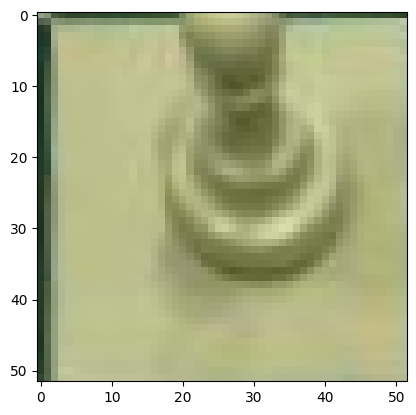

In [8]:
    plt.imshow(getCell[6][1][:,:,::-1])
    plt.show()

In [13]:
model = YOLO("model/yolo8/runs_yolo8/detect/train4/weights/best.pt")
results = model(getCell[6][1], save=True)


0: 416x416 (no detections), 4.9ms
Speed: 0.4ms preprocess, 4.9ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict23


In [10]:
for result in results:
    result.boxes
print(result.boxes)

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.engine.results.Boxes object with attributes:

boxes: tensor([[14.2217,  0.0000, 44.2736, 41.0291,  0.6424,  7.0000],
        [13.9646,  0.0650, 41.8377, 39.8704,  0.4431, 10.0000]], device='cuda:0')
cls: tensor([ 7., 10.], device='cuda:0')
conf: tensor([0.6424, 0.4431], device='cuda:0')
data: tensor([[14.2217,  0.0000, 44.2736, 41.0291,  0.6424,  7.0000],
        [13.9646,  0.0650, 41.8377, 39.8704,  0.4431, 10.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (52, 52)
shape: torch.Size([2, 6])
xywh: tensor([[29.2476, 20.5146, 30.0519, 41.0291],
        [27.9011, 19.9677, 27.8731, 39.8054]], device='cuda:0')
xywhn: tensor([[0.5625, 0.3945, 0.5779, 0.7890],
        [0.5366, 0.3840, 0.5360, 0.7655]], device='cuda:0')
xyxy: tensor([[14.2217,  0.0000, 44.2736, 41.0291],
        [13.9646,  0.0650, 41.8377, 39.8704]], device='cuda:0')
xyxyn: tensor([[0.2735, 0.0000, 0.8514, 0.7890],
        [0.2685, 0.0013, 0.8046, 0.7667]], device='cuda:0')


In [11]:
model = YOLO("model/yolo8/runs_yolo8/detect/train4/weights/best.pt")
results = model('Test/lessmultichess.jpg', save=True, conf=0.5, iou=0.7)


image 1/1 /home/vasu/Documents/chessMooveTrack/Test/lessmultichess.jpg: 416x416 1 white-king, 1 white-pawn, 4.9ms
Speed: 0.3ms preprocess, 4.9ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict22


In [12]:
for res in results:
    print(res)

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'bishop', 1: 'black-bishop', 2: 'black-king', 3: 'black-knight', 4: 'black-pawn', 5: 'black-queen', 6: 'black-rook', 7: 'white-bishop', 8: 'white-king', 9: 'white-knight', 10: 'white-pawn', 11: 'white-queen', 12: 'white-rook'}
orig_img: array([[[194, 199, 198],
        [191, 196, 195],
        [188, 193, 192],
        ...,
        [  0,   1,   1],
        [  0,   2,   2],
        [  0,   2,   2]],

       [[194, 199, 198],
        [193, 198, 197],
        [191, 196, 195],
        ...,
        [  0,   1,   1],
        [  0,   1,   1],
        [  0,   1,   1]],

       [[190, 195, 194],
        [191, 196, 195],
        [193, 198, 197],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  4,   0,   0],
        [  2,   0,   0],
        [  0,   3,   2],
        ...,
     

In [ ]:
GT                  PD
1. e4  d5          1. d4 d5      50

1. e4 e4           2. e4  e4    100

2. d5  